<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Spaceship-Titanic/blob/additional_features/2_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# colab
from google.colab import drive

# data
import pandas as pd

# math
import numpy as np

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

## PEP8 code standard

In [2]:
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

## Importing custom packages

In [3]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

git_download_path = \
    'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [4]:
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers

def reload_modules(modules):
    for module in modules:
        importlib.reload(module)

reload_modules(
    [
        path_manager,
        sklearn_transformers,
        sklearn_utils
    ]
)

from path_manager import PathManager
from sklearn_transformers import ColumnDropper
from sklearn_utils import inf_statistics
from sklearn_transformers import OutlierCleaner

# Set up paths

In [5]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 9
MODELS_TRIAL = 4
COMPETITION_PATH = gdrive_path + 'ML/Competitions/6.SpaceshipTitanic/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Data/preproc_trial_9 already exists
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Models/trial_4 already exists


# Download the data

In [6]:
df_train = pd.read_csv(manager.train_path, index_col='Unnamed: 0')
df_test = pd.read_csv(manager.test_path, index_col='Unnamed: 0')

In [7]:
df_train.columns, df_test.columns

(Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
        'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
        'Name', 'Transported', 'gender'],
       dtype='object'),
 Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
        'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
        'Name', 'gender'],
       dtype='object'))

# Checking NAN

In [ ]:
from sklearn_utils import nan_statistics


_ = nan_statistics(df_train)

Col -- Nan percentage
CryoSleep 2.4962613597147127
ShoppingMall 2.392729782583688
VIP 2.3352122397331185
HomePlanet 2.312205222592891
Name 2.300701714022777
Cabin 2.289198205452663
VRDeck 2.1626596111814105
FoodCourt 2.105142068330841
Spa 2.105142068330841
Destination 2.093638559760727
RoomService 2.082135051190613
Age 2.0591280340503855


In [ ]:
_ = nan_statistics(df_test)

Col -- Nan percentage
FoodCourt 2.4783726911386488
Spa 2.3614683189151275
Cabin 2.338087444470423
ShoppingMall 2.2913256955810146
Name 2.197802197802198
CryoSleep 2.1744213233574934
VIP 2.1744213233574934
Destination 2.1510404489127897
Age 2.127659574468085
HomePlanet 2.034136076689268
RoomService 1.917231704465747
VRDeck 1.8704699555763384


# Check infinity values

In [ ]:
from sklearn_utils import inf_statistics


inf_statistics(df_train)

Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
gender          0
dtype: int64


Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
gender          0
dtype: int64

In [ ]:
inf_statistics(df_test)

Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
gender          0
dtype: int64


Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
gender          0
dtype: int64

In [ ]:
df_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
gender            int64
dtype: object

# Engineer new features

## Did a person buy any luxury service?

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin


class BoughtLuxuryItems(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        transformed_df = X.copy()
        transformed_df['BoughtAnyLuxury'] = \
            (transformed_df['ShoppingMall'] > 0.0) \
            | (transformed_df['FoodCourt'] > 0.0) \
            | (transformed_df['VRDeck'] > 0.0) \
            | (transformed_df['Spa'] > 0.0) \
            | (transformed_df['RoomService'] > 0.0)
        return transformed_df


pep8(_ih)

In [9]:
bought_luxury_items = BoughtLuxuryItems()

df_train = bought_luxury_items.fit_transform(df_train)
df_test = bought_luxury_items.transform(df_test)

## DeckNum, DeckSide, Deck

In [10]:
from sklearn.base import TransformerMixin, BaseEstimator


class DeckNumAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def get_deck_num(self, deck):
        if type(deck) is str:
            split_items = deck.split('/')
            return int(split_items[1])
        else:
            return np.nan

    def transform(self, X, y=None):
        df_transformed = X.copy()
        df_transformed['DeckNum'] = df_transformed['Cabin'] \
            .map(self.get_deck_num)
        return df_transformed


pep8(_ih)

In [11]:
deck_num_adder = DeckNumAdder()
df_train = deck_num_adder.fit_transform(df_train)
df_test = deck_num_adder.transform(df_test)

In [13]:
from sklearn_utils import nan_statistics

nan_statistics(df_train)

Col -- Nan percentage
CryoSleep 2.4962613597147127
ShoppingMall 2.392729782583688
VIP 2.3352122397331185
HomePlanet 2.312205222592891
Name 2.300701714022777
Cabin 2.289198205452663
DeckNum 2.289198205452663
VRDeck 2.1626596111814105
FoodCourt 2.105142068330841
Spa 2.105142068330841
Destination 2.093638559760727
RoomService 2.082135051190613
Age 2.0591280340503855


{'HomePlanet': 2.312205222592891,
 'CryoSleep': 2.4962613597147127,
 'Cabin': 2.289198205452663,
 'Destination': 2.093638559760727,
 'Age': 2.0591280340503855,
 'VIP': 2.3352122397331185,
 'RoomService': 2.082135051190613,
 'FoodCourt': 2.105142068330841,
 'ShoppingMall': 2.392729782583688,
 'Spa': 2.105142068330841,
 'VRDeck': 2.1626596111814105,
 'Name': 2.300701714022777,
 'DeckNum': 2.289198205452663}

In [14]:
from sklearn.base import TransformerMixin, BaseEstimator


class DeckSideAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def add_deck_side(self, val):
        if type(val) is str:
            return val.split('/')[2]
        else:
            return np.nan

    def transform(self, X, y=None):
        df_transformed = X.copy()
        df_transformed['DeckSide'] = df_transformed['Cabin'].map(
            self.add_deck_side)

        del X
        return df_transformed


pep8(_ih)

In [15]:
deck_side_adder = DeckSideAdder()

df_train = deck_side_adder.fit_transform(df_train)
df_test = deck_side_adder.transform(df_test)

In [19]:
from sklearn.base import TransformerMixin, BaseEstimator


class DeckAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def add_deck(self, val):
        if type(val) is str:
            return val.split('/')[0]
        else:
            return np.nan

    def transform(self, X, y=None):
        transformed_df = X.copy()
        transformed_df['Deck'] = transformed_df['Cabin'].map(
            self.add_deck
        )
        del X
        return transformed_df


pep8(_ih)

In [20]:
deck_adder = DeckAdder()
df_train = deck_adder.fit_transform(df_train)
df_test = deck_adder.transform(df_test)

## PassengerGroup, PassengerPosition, SingleInGroup, GroupSize



In [21]:
from sklearn.base import TransformerMixin, BaseEstimator


class PassengerGroupAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def get_passenger_group(self, val):
        if val is not np.nan:
            return int(val.split('_')[0])
        else:
            return val

    def transform(self, X, y=None):
        transformed_df = X.copy()
        transformed_df['PassengerGroup'] = \
            X['PassengerId'].map(self.get_passenger_group)
        del X
        return transformed_df


pep8(_ih)

In [22]:
group_adder = PassengerGroupAdder()
df_train = group_adder.fit_transform(df_train)
df_test = group_adder.transform(df_test)

In [23]:
from sklearn.base import TransformerMixin, BaseEstimator


class PassengerPositionAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def get_position(self, val):
        return int(val.split('_')[1])
    
    def transform(self, X, y=None):
        # df_transformed = X.copy()
        # del X
        X['PassengerGroupPosition'] = \
            X['PassengerId'].map(self.get_position)
        return X

In [24]:
position_adder = PassengerPositionAdder()
df_train = position_adder.fit_transform(df_train)
df_test = position_adder.transform(df_test)

In [25]:
from sklearn.base import TransformerMixin, BaseEstimator


class GroupSizeAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.value_counts = None

    def fit(self, X, y=None):
        self.value_counts = X['PassengerGroup'].value_counts()
        return self

    def get_group_size(self, val):
        return self.value_counts.loc[val]

    def transform(self, X, y=None):
        X['GroupSize'] = \
            X['PassengerGroup'].map(self.get_group_size)
        X['AloneInGroup'] = X['GroupSize'] == 1
        return X
    

In [26]:
adder = GroupSizeAdder()
df_train = adder.fit_transform(df_train)

# Fit transform on test, because
# contains group numbers, not present in df_train
df_test = adder.fit_transform(df_test)

## Total spend

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin


class TotalSpender(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['TotalSpend'] = \
            X['Spa'] \
            + X['FoodCourt'] \
            + X['VRDeck'] \
            + X['RoomService'] \
            + X['ShoppingMall']
        X['ZeroSpend'] = X['TotalSpend'] <= 0
        return X

In [31]:
total_spend_adder = TotalSpender()

df_train = total_spend_adder.fit_transform(df_train)
df_test = total_spend_adder.transform(df_test)

## Total spend categorized

In [33]:
def categorize_total_spend(dfs_):
    for df_ in dfs_:
        df_['SpendCategory'] = ''
        df_.loc[df_['TotalSpend'].between(-1, 1, 'left'), 'SpendCategory'] = \
            'ZeroSpend'
        df_.loc[df_['TotalSpend'].between(1, 800, 'both'), 'SpendCategory'] = \
            'Under800'
        df_.loc[df_['TotalSpend'].between(800, 1200, 'right'), 'SpendCategory'] = \
            'Median1200'
        df_.loc[df_['TotalSpend'].between(1200, 2700, 'right'), 'SpendCategory'] = \
            'Upper2700'
        df_.loc[df_['TotalSpend'].between(2700, 100000, 'right'), 'SpendCategory'] = \
            'BigSpender'

        df_['SpendCategory'] = \
            df_['SpendCategory'].astype('category')

categorize_total_spend([df_train, df_test])

## Categorized Age

In [34]:
def categorize_age(dfs_):
    # -1, 5 - is a specific range,
    # 70% probability of being transported
    # for the kids in this range
    bins = [-1, 5, 18, 30, 50, 100]
    labels = [i for i in range(len(bins) - 1)]
    for df in dfs_:
        df['AgeGroup'] = pd.cut(
            df['Age'],
            bins=bins,
            labels=labels,
            duplicates='drop'
        )
        # df.loc[df['Age'].between(0, 10, 'both'), 'AgeGroup'] = 'Kids'
        # df.loc[df['Age'].between(10, 18, 'right'), 'AgeGroup'] = 'Teens'
        # df.loc[df['Age'].between(18, 35, 'right'), 'AgeGroup'] = 'Middle'
        # df.loc[df['Age'].between(35, 50, 'right'), 'AgeGroup'] = 'Senior'
        # df.loc[df['Age'].between(50, 100, 'right'), 'AgeGroup'] = 'Old'

categorize_age(
    [df_train, df_test]
)

In [35]:
assert 'AgeGroup' in df_train.columns and 'AgeGroup' in df_test.columns

df_train.AgeGroup.value_counts(normalize=True)

2    0.380315
3    0.314071
1    0.160442
4    0.086563
0    0.058609
Name: AgeGroup, dtype: float64

In [36]:
from sklearn_utils import nan_statistics


_ = nan_statistics(df_train[['AgeGroup']])

Col -- Nan percentage
AgeGroup 2.0591280340503855


## Total spend per group

In [40]:
df_train.groupby('PassengerGroup').aggregate('sum').loc[
    :, ['GroupSize', 'TotalSpend']
]

,GroupSize,TotalSpend
PassengerGroup,,
1,1,0.0
2,1,736.0
3,4,15559.0
4,1,1091.0
5,1,774.0
...,...,...
9275,9,4771.0
9276,1,8536.0
9278,1,0.0


In [47]:
from sklearn.base import BaseEstimator, TransformerMixin


class PerGroupSpender(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.total_spend_per_group_data = {}

    def fit(self, X, y=None):
        # self.total_spend_per_group_data = \
        #     X \
        #     .groupby('PassengerGroup') \
        #     .aggregate('sum') \
        #     .loc[:, ['TotalSpend']]
        unique_groups = X['PassengerGroup'].unique()

        for unique_group in unique_groups:
            group_subset = X.loc[
                X['PassengerGroup'] == unique_group,
                ['TotalSpend']
            ]
            total_spend_per_group = \
                group_subset.fillna(group_subset.median()).sum() \
                / len(group_subset)

            self.total_spend_per_group_data[unique_group] = \
                total_spend_per_group
        return self

    def transform(self, X, y=None):
        X['TotalSpendPerGroup'] = \
            X['PassengerGroup'].map(
                lambda val: self.total_spend_per_group_data[val][0])
        return X


pep8(_ih)

In [48]:
per_group_spender = PerGroupSpender()
df_train = per_group_spender.fit_transform(df_train)

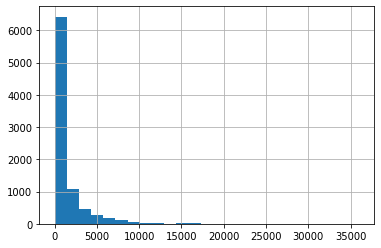

In [49]:
df_train['TotalSpendPerGroup'].hist(bins=25)

In [50]:
# Yes, fit_transform on the test data, because
# test set can contain other groups
df_test = per_group_spender.fit_transform(df_test)

## Is from spendless group?

In [51]:
feature = 'IsFromSpendlessGroup'
df_train[feature] = (df_train['TotalSpendPerGroup'] == 0).astype('int')
df_test[feature] = (df_test['TotalSpendPerGroup'] == 0).astype('int')

## Feature cross - VIP + CryoSleep (Not worth it, only ~20 people out of 8000 are VIP and cryo sleep)

In [46]:
# def feature_cross(df_):
#     df_['VIPxCryoSleep'] = \
#         ((df_['VIP']==1) & (df_['CryoSleep']==1)).astype(int)
#     return df_

# df_train = feature_cross(df_train)
# df_test = feature_cross(df_test)

# df_train.VIPxCryoSleep.value_counts(), \
#     df_test.VIPxCryoSleep.value_counts()

(0    8672
 1      21
 Name: VIPxCryoSleep, dtype: int64, 0    4270
 1       7
 Name: VIPxCryoSleep, dtype: int64)

## Categorized group size

In [52]:
def categorize(dfs_):
    bins = [0, 3, 6, 10]
    labels = [i for i in range(len(bins) - 1)]
    for df in dfs_:
        df['GroupSizeCat'] = \
            pd.cut(
                df['GroupSize'],
                bins=bins,
                labels=labels,
                duplicates='drop')
categorize([df_train, df_test])

In [53]:
df_train.GroupSizeCat.value_counts(), \
    df_test.GroupSizeCat.value_counts()

(0    7507
 1     851
 2     335
 Name: GroupSizeCat, dtype: int64, 0    3734
 1     397
 2     146
 Name: GroupSizeCat, dtype: int64)

# Clean outliers

In [57]:
from sklearn_transformers import OutlierCleaner

columns_to_clean = [
        'VRDeck',
        'Spa',
        'RoomService',
        'FoodCourt',
        'ShoppingMall',
        'TotalSpend',
        'TotalSpendPerGroup',
        'Age'
]

cleaner = OutlierCleaner(
    columns_to_clean,
    lower_quantile_=0.05,
    upper_quantile_=0.95
)

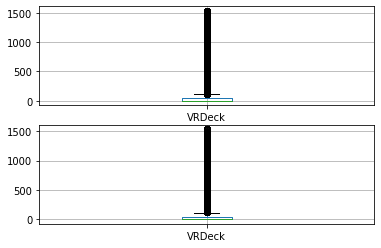

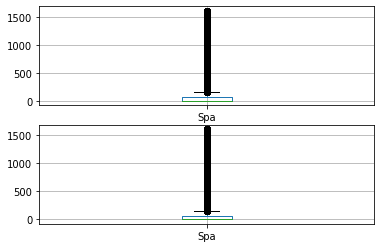

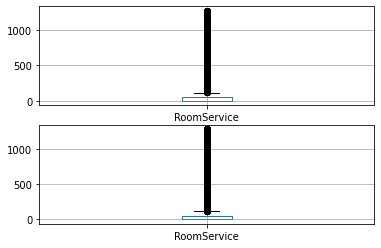

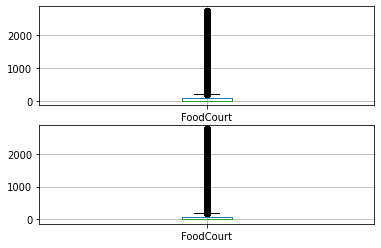

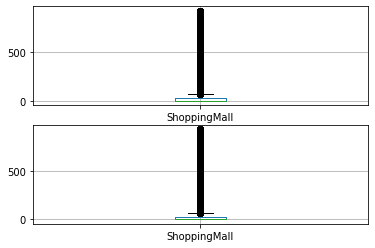

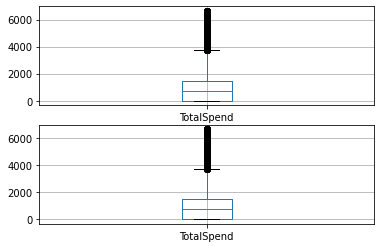

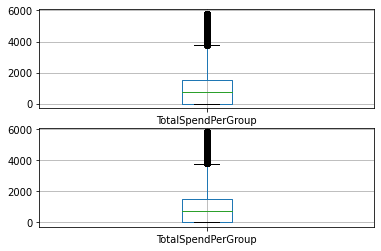

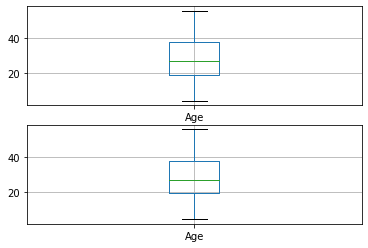

In [58]:
df_result = cleaner.fit_transform(df_train)

import matplotlib.pyplot as plt
for column in columns_to_clean:
    fig, ax = plt.subplots(2, 1)
    df_train.boxplot([column], ax=ax[0])
    df_result.boxplot([column], ax=ax[1])

In [40]:
df_train = cleaner.fit_transform(df_train)
df_test = cleaner.transform(df_test)

# Reduce number precision

In [ ]:
def reduce_precision(
    df_,
    original_dtypes_=['float64'],
    transcription_dict_={
        'float64': 'float32',
        'int64': 'int32'
    }
):
    '''
    For every column, that has a dtype in original_dtypes
    list --> it changes the original dtype, according to
    the transcription_dict_
    '''
    for numeric_type in original_dtypes_:
        mask = np.isin(df_.dtypes, [numeric_type])
        df_.loc[:, mask] = \
            df_.loc[:, mask].astype(transcription_dict_[numeric_type])
    return df_

In [ ]:
df_train = reduce_precision(df_train)

In [ ]:
df_test = reduce_precision(df_test)

In [ ]:
common_columns = set(df_train.columns).intersection(
    df_test.columns
)

assert (df_train.loc[:, common_columns].dtypes == \
        df_test.loc[:, common_columns].dtypes).all()

# Removing NAN / INF columns

- No columns with high content of NAN / INF values encountered

# Preparing processing pipelines

In [ ]:
luxury_columns = [
    'RoomService',
    'FoodCourt',
    'ShoppingMall',
    'Spa',
    'VRDeck',
    'TotalSpend',
    'TotalSpendPerGroup'
]

luxury_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median')),
        ('standardize', StandardScaler())
    ]
)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder


spend_category_columns = [
    'Spend_Category'
]

spend_category_pipeline = Pipeline(
    [
        ('encode', OrdinalEncoder(
            categories = [
                [
                    '',
                    'Zero_Spend',
                    'Under_800',
                    'Median_1200',
                    'Upper_2700',
                    'Big_Spender'
                ]
            ]
        ))
    ]
)

In [ ]:
age_group_columns = [
    'AgeGroup'
]

age_group_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent')),
        # ('encode', OrdinalEncoder(
        #     categories = [
        #         [
        #             'Kids',
        #             'Teens',
        #             'Middle',
        #             'Senior',
        #             'Old'
        #         ]
        #     ]
        # ))
    ]
)

In [ ]:
is_from_spendless_group_columns = [
    'IsFromSpendlessGroup'
]

is_from_spendless_group_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent'))
    ]
)

In [ ]:
name_columns = [
    'Name'
]

name_pipeline = Pipeline(
    [
        ('drop', ColumnDropper(name_columns))
    ]
)

In [ ]:
age_columns = [
    'Age'
]

age_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median')),
        ('standardize', StandardScaler())
    ]
)

In [ ]:
home_planet_columns = [
    'HomePlanet'
]

home_planet_pipeline = Pipeline(
    [
        # ('impute', SimpleImputer(missing_values=np.nan, strategy='constant')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [ ]:
destination_columns = [
    'Destination'
]

destination_pipeline = Pipeline(
    [
        # ('impute', SimpleImputer(strategy='median')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [ ]:
passenger_id_columns = [
    'PassengerId'
]

passenger_id_pipeline = Pipeline(
    [
        # ('impute', SimpleImputer(strategy='median')),
        ('drop', ColumnDropper(passenger_id_columns))
    ]
)

In [ ]:
cabin_columns = [
    'Cabin'
]

cabin_pipeline = Pipeline(
    [
        ('drop', ColumnDropper(cabin_columns))
    ]
)

In [59]:
df_train.CryoSleep.value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [ ]:
# Consider here also one-hot encoding, substituting
# NAN values as "Missing"

cryo_sleep_columns = [
    'CryoSleep'
]

cryo_sleep_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent'))
    ]
)

In [60]:
df_train.VIP.value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [61]:
vip_columns = [
    'VIP'
]

vip_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent'))
    ]
)

In [62]:
df_train.BoughtAnyLuxury.value_counts()

True     5040
False    3653
Name: BoughtAnyLuxury, dtype: int64

In [63]:
bought_any_luxury_columns = [
    'BoughtAnyLuxury'
]

bought_any_luxury_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent')),
    ]
)

In [64]:
df_train.Deck.value_counts()

F               2794
G               2559
E                876
B                779
C                747
D                478
A                256
NOT ASSIGNED     199
T                  5
Name: Deck, dtype: int64

In [ ]:
from sklearn.preprocessing import OrdinalEncoder


deck_columns = [
    'Deck'
]

deck_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent')),
        (
            'encode',
            OrdinalEncoder(
                categories=[
                    [
                        # 'NOT ASSIGNED',
                        'A',
                        'B',
                        'C',
                        'D',
                        'E',
                        'F',
                        'G',
                        'T'
                    ]
                ]
            )
        )
    ]
)

In [ ]:
deck_num_columns = [
    'DeckNum'
]

deck_num_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('scale', StandardScaler())
    ]
)

In [ ]:
deck_size_columns = [
    'DeckSide'
]

deck_side_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [ ]:
alone_columns = ['AloneInGroup']
alone_pipeline = Pipeline(
    [('impute', SimpleImputer(strategy='most_frequent'))]
)

In [ ]:
group_position_columns = ['PassengerGroupPosition']
group_position_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('scale', StandardScaler())
    ]
)

In [ ]:
group_size_columns = ['GroupSize']
group_size_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]
)

In [ ]:
passenger_group_columns = ['PassengerGroup']
passenger_group_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]
)

In [ ]:
gender_columns = ['gender']
gender_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent'))
    ]
)

In [ ]:
# all_columns = set()
all_columns = set(
    [
        *luxury_columns,
        *name_columns,
        *age_columns,
        *home_planet_columns,
        *destination_columns,
        *passenger_id_columns,
        *cabin_columns,
        *vip_columns,
        *cryo_sleep_columns,
        *bought_any_luxury_columns,
        *deck_columns,
        *deck_num_columns,
        *deck_size_columns,
     
        *alone_columns,
        *group_position_columns,
        *group_size_columns,
        *passenger_group_columns,
        *gender_columns,
     
        *spend_category_columns,
        *age_group_columns,
        *is_from_spendless_group_columns,
     

    ]
)

# print(df_train.columns)
assert (set(df_train.columns) - all_columns) == {'Transported'}, \
    print(set(df_train.columns) - all_columns)

In [ ]:
from sklearn_transformers import ColumnDropper


preprocessor = ColumnTransformer(
    [
        ('luxury', luxury_pipeline, luxury_columns),
        ('drop', name_pipeline, name_columns),
        ('age', age_pipeline, age_columns),
        ('home_planet', home_planet_pipeline, home_planet_columns),
        ('destination', destination_pipeline, destination_columns),
        ('passenger_id', passenger_id_pipeline, passenger_id_columns),
        ('vip', vip_pipeline, vip_columns),
        ('cryo_sleep', cryo_sleep_pipeline, cryo_sleep_columns),
        ('cabin', cabin_pipeline, cabin_columns),
        
        ('bought_any_luxury', bought_any_luxury_pipeline, bought_any_luxury_columns),
        ('deck', deck_pipeline, deck_columns),
        ('deck_num', deck_num_pipeline, deck_num_columns),
        ('deck_side', deck_side_pipeline, deck_size_columns),
        
        ('alone_in_group', alone_pipeline, alone_columns),
        ('passenger_group_position', group_position_pipeline, group_position_columns),
        ('group_size', group_size_pipeline, group_size_columns),
        ('passenger_group', passenger_group_pipeline, passenger_group_columns),
        ('gender', gender_pipeline, gender_columns),
     
        # ('spend_category', spend_category_pipeline, spend_category_columns),
        # ('age_group', age_group_pipeline, age_group_columns),
        # ('is_from_spendless_group', is_from_spendless_group_pipeline,
        #     is_from_spendless_group_columns),
        
        ('transported', 'passthrough', ['Transported'])
    ],
    remainder='drop'
)

# Splitting the training data

## Split the data

In [ ]:
from sklearn.model_selection import train_test_split

TRAIN_VAL_PERCENTAGE = 0.8
RANDOM_STATE = 42

df_trainval, df_test_sample = train_test_split(
    df_train,
    train_size=TRAIN_VAL_PERCENTAGE,
    random_state=RANDOM_STATE,
    stratify=df_train['Transported']
)

df_trainval.shape, df_test_sample.shape

((6954, 28), (1739, 28))

## Check class balance and feature distribution after splitting

In [ ]:
print(df_trainval.Transported.value_counts())
print(df_test_sample.Transported.value_counts())

True     3502
False    3452
Name: Transported, dtype: int64
True     876
False    863
Name: Transported, dtype: int64


Visualizing datasets distributions


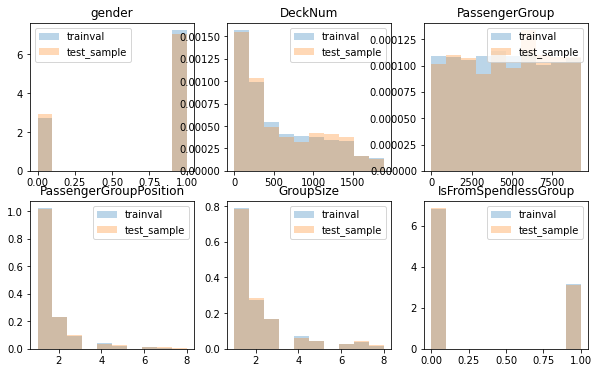

In [ ]:
from sklearn_utils import visualize_datasets_distributions

visualize_datasets_distributions(
    dataframes_dict_={
        'trainval': df_trainval,
        'test_sample': df_test_sample
    },
    columns_=df_trainval.columns[np.isin(df_trainval.dtypes, ['float32', 'int', ''])]
)

# Process data

In [ ]:
df_trainval_processed = preprocessor.fit_transform(
    df_trainval
)

col_n = -1
assert (df_trainval_processed[:, col_n] == df_trainval['Transported']).all()

In [ ]:
df_test_sample_processed = preprocessor.transform(
    df_test_sample
)
assert (df_test_sample_processed[:, -1] == df_test_sample['Transported']).all()

In [ ]:
df_test['Transported'] = np.zeros(len(df_test))
df_test_processed = preprocessor.transform(df_test)

# removing fake "Transported" column
df_test_processed = df_test_processed[:, :-1]

In [ ]:
assert (df_trainval_processed.dtype == 'float64') \
    & (df_test_sample_processed.dtype == 'float64') \
    & (df_test_processed.dtype == 'float64')

In [ ]:
print(
    df_trainval_processed.shape,
    df_test_sample_processed.shape
    df_test_processed.shape,
)

(6954, 30) (4277, 29) (1739, 30)


# Feature selection

In [ ]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

PERCENTILE = 80

feature_selector = SelectPercentile(
    score_func=f_classif,
    percentile=80
)
feature_selector.fit(
    df_trainval_processed[:, :-1],
    df_trainval_processed[:, -1]
)

SelectPercentile(percentile=80)

<BarContainer object of 26 artists>

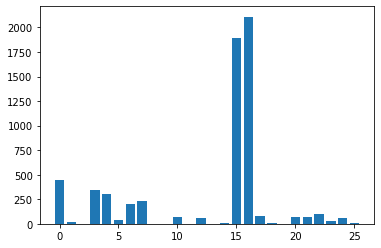

In [ ]:
plt.bar(
    list(range(len(feature_selector.scores_))),
    feature_selector.scores_,
)

In [ ]:
X_trainval_processed = feature_selector.fit_transform(
    df_trainval_processed[:, :-1], df_trainval_processed[:, -1])

X_test_sample_processed = feature_selector.transform(
    df_test_sample_processed[:, :-1]
)

X_test_processed = feature_selector.transform(
    df_test_processed
)

In [ ]:
df_trainval_processed = np.hstack(
    [
        X_trainval_processed,
        df_trainval_processed[:, -1].reshape(X_trainval_processed.shape[0], 1)
    ]
)

assert (df_trainval_processed[:, -1] == df_trainval.Transported).all()

In [ ]:
df_test_sample_processed = np.hstack(
    [
        X_test_sample_processed,
        df_test_sample_processed[:, -1].reshape(X_test_sample_processed.shape[0], 1)
    ]
)

assert (df_test_sample_processed[:, -1] == df_test_sample.Transported).all()

In [ ]:
df_test_processed = X_test_processed

# Save the data

In [ ]:
df_trainval_processed.shape[1]

30

In [ ]:
pd.DataFrame(df_test_processed).head(10)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.699062,-0.764095,-0.114970,1.0,0.0,...,7.0,-1.133617,0.0,0.0,1.0,1.0,-0.490454,-0.650221,-1.721578,1.0
1,-0.459516,-0.396737,-0.441999,3.460743,-0.426892,0.959634,1.012832,-0.672356,1.0,0.0,...,6.0,-1.131666,0.0,0.0,1.0,1.0,-0.490454,-0.650221,-1.719705,1.0
2,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.699062,-0.764095,0.163723,0.0,1.0,...,3.0,-1.139468,0.0,0.0,1.0,1.0,-0.490454,-0.650221,-1.719331,1.0
3,-0.459516,3.565931,-0.441999,0.008622,1.044590,3.189737,2.863421,0.651436,0.0,1.0,...,3.0,-1.137518,0.0,0.0,1.0,1.0,-0.490454,-0.650221,-1.718582,1.0
4,-0.431524,-0.409755,1.967707,-0.429520,-0.426892,-0.321287,-0.359393,-0.602683,1.0,0.0,...,6.0,-1.129715,0.0,0.0,1.0,1.0,-0.490454,-0.650221,-1.717832,1.0
5,-0.459516,1.926331,0.556037,-0.155984,-0.275971,0.502204,0.522796,0.163723,1.0,0.0,...,6.0,-1.125814,0.0,1.0,0.0,1.0,-0.490454,-0.650221,-1.716334,1.0
6,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.273260,-0.764095,-0.533010,0.0,1.0,...,2.0,-1.135567,0.0,1.0,0.0,1.0,-0.490454,-0.650221,-1.715585,0.0
7,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.699062,-0.764095,-0.602683,0.0,1.0,...,4.0,-1.139468,0.0,0.0,1.0,0.0,-0.490454,-0.020116,-1.714461,1.0
8,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.699062,-0.764095,-0.393663,0.0,1.0,...,4.0,-1.139468,0.0,0.0,1.0,0.0,0.470554,-0.020116,-1.714461,1.0
9,-0.459516,0.514554,-0.441999,-0.429520,-0.426892,-0.324801,-0.363157,-0.323990,1.0,0.0,...,6.0,-1.125814,0.0,0.0,1.0,1.0,-0.490454,-0.650221,-1.714087,1.0


In [ ]:
assert df_trainval_processed.shape[1] \
    == df_test_sample_processed.shape[1] \
    == df_test_processed.shape[1] + 1

manager.save_to_csv(
    df_trainval_processed,
    manager.data_trial_path,
    'trainval_processed.csv'
)

manager.save_to_csv(
    df_test_sample_processed,
    manager.data_trial_path,
    'test_sample_processed.csv'
)

manager.save_to_csv(
    df_test_processed,
    manager.data_trial_path,
    'test_processed.csv'
)